<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Test what is the decoding change for single size training 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import Nets
from Nets import*

import navigation2
from navigation2 import *

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

## Test driven action Statistics 

In [36]:
# 2 clicks performance
def Force_action(x, y, start, type_):
    dict_a = {'up':0, 'right':1, 'down':2, 'left':3 }
    if type_ == 0:
        force_actions = (16 - start[1]) * [dict_a['right']] +  (14-x) * [dict_a['left']]\
        + (16 - start[0]) * [dict_a['down']] + (14-y) * [dict_a['up']]
    elif type_ == 1:
        force_actions = (16 - start[1]) * [dict_a['right']] +  (14-x) * [dict_a['left']] \
        + (start[0] - 2) * [dict_a['up']] + y * [dict_a['down']]
    elif type_ == 2:
        force_actions = (start[1] - 2) * [dict_a['left']] +  x * [dict_a['right']] \
        + (16 - start[0]) * [dict_a['down']]  + (14-y) * [dict_a['up']]
    elif type_ == 3:
        force_actions = (start[1] - 2) * [dict_a['left']] +  x * [dict_a['right']] \
        + (start[0] - 2) * [dict_a['up']] + y * [dict_a['down']]
    elif type_ == 4:
        force_actions = (16 - start[0]) * [dict_a['down']] +  (14-y) * [dict_a['up']] \
        + (16 - start[1]) * [dict_a['right']] + (14-x) * [dict_a['left']]
    elif type_ == 5:
        force_actions = (16 - start[0]) * [dict_a['down']] +  (14-y) * [dict_a['up']] \
        + (start[1] - 2) * [dict_a['left']]  + x * [dict_a['right']]
    elif type_ == 6:
        force_actions = (start[0] - 2) * [dict_a['up']] +  y * [dict_a['down']]\
        + (16 - start[1]) * [dict_a['right']]  + (14-x) * [dict_a['left']]
    elif type_ == 7:
        force_actions = (start[0] - 2) * [dict_a['up']] +  y * [dict_a['down']] \
        + (start[1] - 2) * [dict_a['left']]  + x * [dict_a['right']]
    return force_actions

def clicks_count(weight, type_ = 0):
    size = 15
    PC_traces = []
    Pretest =  PretrainTest(holes = 0, weight_write = weight, inputs_type=(1, 0)) 
    Pretest.game.net.load_state_dict(torch.load(weight))
    # torch.manual_seed(5)
    hidden = torch.randn(1, 512)
    score_2 = []
    # scan different points
    Score_2 = np.zeros((19, 19))
    for y in np.arange(0, 15, 1):
        for x in np.arange(0, 15, 1):
            score = 0
            for i in range(50):
                start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
#                 force_actions = (size+2-start[1]) * [1] +  x * [3] + (start[0]+1-2) * [0] + 2 * [1] + y * [2]
#                 force_actions2 = (size+2-start[1]) * [1] +  x * [3] + size+1-start[0] * [2] + 2 * [1] + y * [0]
                force_actions = Force_action(x, y, start, type_)
                Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 0, size = size, test = 0, hidden = hidden,
                                                                        force_actions = force_actions, limit_set = 16)
                start_new = Pos1[len(force_actions)]
                grid = Pretest.game.grid.grid.copy()
                pos_r = (Pretest.game.pos_reward)
                manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
                score_2.append(manhantondist/(len(Pos1)-len(force_actions)-1))
                score += len(Pos1)-len(force_actions)-1
            score = score/50.                                                             
            Score_2[start_new[0], start_new[1]] = score                                                          
    print (np.mean(score_2))
    return score_2, Score_2  


In [37]:
# 1clicks performance
def Force_action_1(x, y, start, type_):
    dict_a = {'up':0, 'right':1, 'down':2, 'left':3 }
    if type_ == 0:
        force_actions = (16 - start[0]) * [dict_a['down']] +  y * [dict_a['up']]
    elif type_ == 1:
        force_actions = (start[0] - 2) * [dict_a['up']] + y * [dict_a['down']]
    elif type_ == 2:
        force_actions = (16 - start[1]) * [dict_a['right']] + y * [dict_a['left']]
    elif type_ == 3:
        force_actions = (start[1] - 2) * [dict_a['left']]  + y * [dict_a['right']]
    return force_actions

In [38]:
# 1clicks performance
def Force_action_1(x, y, start, type_):
    dict_a = {'up':0, 'right':1, 'down':2, 'left':3 }
    if type_ == 0:
        force_actions = (16 - start[0]) * [dict_a['down']] +  (16 - start[0]) * [dict_a['up']]
    elif type_ == 1:
        force_actions = (start[0] - 2) * [dict_a['up']] + (start[0] - 2) * [dict_a['down']]
    elif type_ == 2:
        force_actions = (16 - start[1]) * [dict_a['right']] + (16 - start[1]) * [dict_a['left']]
    elif type_ == 3:
        force_actions = (start[1] - 2) * [dict_a['left']]  + (start[1] - 2) * [dict_a['right']]
    return force_actions
# try to compare from each new starting position, what is performance compared to 
# without driven action
def clicks_count_1(weight, type_ = 0):
    size = 15
    PC_traces = []
    Pretest =  PretrainTest(holes = 0, weight_write = weight, inputs_type=(1, 0)) 
    Pretest.game.net.load_state_dict(torch.load(weight))
    # torch.manual_seed(5)
    hidden = torch.randn(1, 512)
    # for all points 
    score_1 = []
    # scan different points
    Score_1 = np.zeros((19, 19))
    for y in np.arange(2, 17, 1):
        for x in np.arange(2, 17, 1):
            score = 0
            for i in range(50):
                start = (y, x)
                force_actions = Force_action_1(x, y, start, type_)
                Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 0, size = size, test = 0\
                                                                         ,force_actions = force_actions, limit_set = 16)
                start_new = Pos1[len(force_actions)]
               
                pos_r = (Pretest.game.pos_reward)
                manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
                score_1.append(manhantondist/(len(Pos1)-len(force_actions)-1))
                score += len(Pos1)-len(force_actions)-1
            score = score/50.                                                             
            Score_1[start_new[0], start_new[1]] = score                                                          
    print (np.mean(score_1))
    return score_1, Score_1  

In [39]:

def zero_click(weight):
    size = 15
    PC_traces = []
    Pretest =  PretrainTest(holes = 0, weight_write = weight, inputs_type=(1, 0)) 
    Pretest.game.net.load_state_dict(torch.load(weight))
    # torch.manual_seed(5)
    hidden = torch.randn(1, 512)
    score_0 = []
    Scores = np.zeros((19, 19))
    for y in np.arange(2, 17, 1):
        for x in np.arange(2, 17, 1):
            score = 0
            for i in range(50):
                start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
                start = (y, x)
                force_actions = []
                Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 1, size = size, test = 0, hidden = hidden,
                                                                        force_actions = force_actions, limit_set = 16)
            #     Pos2, hidden2, dH2, Action, reward2 = trajectory(Pretest.game, start, reward_control = 1, size = size, test = 0)
                start_new = Pos1[len(force_actions)]
                grid = Pretest.game.grid.grid.copy()
                pos_r = (Pretest.game.pos_reward)
                manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
                score_0.append(manhantondist/(len(Pos1)-len(force_actions)-1))
                score += len(Pos1)-1
            score = score/50.                                                             
            Scores[start[0], start[1]] = score                                                          
    print (np.mean(score_0))
    return score_0, Scores 

In [40]:
weight = 'weights2/rnn_1515tanh512_checkpoint300_0_5'
Score_0, Scores0_matrix_0 = zero_click(weight)

0.5067840186549837


In [41]:
weight = 'weights2/rnn_1515tanh512_checkpoint300_0_5'
Score_1＿0 = []
Scores1_matrix_0 = np.zeros((4, 19, 19))
for i in range(4):
    score_1, Scores = clicks_count_1(weight, type_ = i)
    Scores1_matrix_0[i] = Scores
    Score_1_0.append(score_1)

0.6424627875054978
0.7357339015405493
0.6073614388303603
0.6127563755133529


In [42]:
weight = 'weights2/rnn_1515tanh512_checkpoint300_0_5'
Score_2_0 = []
Scores2_matrix_0 = np.zeros((8, 19, 19))
for i in range(8):
    score_2, Scores = clicks_count(weight, type_ = i)
    Scores2_matrix_0[i] = Scores
    Score_2_0.append(score_2)

0.7043142560738856
0.7885964830456569
0.7385288844196563
0.8190891151183887
0.7145570377922831
0.7536676918192262
0.7823957969500824
0.8052680506156357


(0.5067840186549837, 0.6495786258474402, 0.7633021644793518)

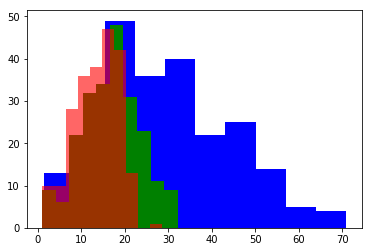

In [53]:
plt.hist(Scores0_matrix_0[2:17, 2:17].ravel(), color = 'b')
plt.hist(np.mean(Scores1_matrix_0[:, 2:17, 2:17], axis = 0).ravel(), color = 'g')
plt.hist(np.mean(Scores2_matrix_0[:, 2:17, 2:17], axis = 0).ravel(), color = 'r', alpha = 0.6)
np.mean(Score_0), np.mean(Score_1_0), np.mean(Score_2_0)

In [44]:
np.save('Scores0_matrix_0.npy', Scores0_matrix_0)
np.save('Scores1_matrix_0.npy', Scores1_matrix_0)
np.save('Scores2_matrix_0.npy', Scores2_matrix_0)

In [45]:
np.save('Scores0_0.npy', Score_0)
np.save('Scores1_0.npy', Score_1_0)
np.save('Scores2_0.npy', Score_2_0)

In [46]:
np.save('Scores0_matrix_0_3.npy', Scores0_matrix_0)
np.save('Scores1_matrix_0_3.npy', Scores1_matrix_0)
np.save('Scores2_matrix_0_3.npy', Scores2_matrix_0)
np.save('Scores0_0_3.npy', Score_0)
np.save('Scores1_0_3.npy', Score_1_0)
np.save('Scores2_0_3.npy', Score_2_0)

In [47]:
np.save('Scores0_matrix_0_4.npy', Scores0_matrix_0)
np.save('Scores1_matrix_0_4.npy', Scores1_matrix_0)
np.save('Scores2_matrix_0_4.npy', Scores2_matrix_0)
np.save('Scores0_0_4.npy', Score_0)
np.save('Scores1_0_4.npy', Score_1_0)
np.save('Scores2_0_4.npy', Score_2_0)

## Compare three networks

Score_0_0 = np.load('Scores0_0.npy')
Score_1_0 = np.load('Scores1_0.npy')
Score_2_0 = np.load('Scores2_0.npy')

Scores_0_0 = []
Scores_1_0 = []
Scores_2_0 = []
for  i in range(5):
    if i == 0:
        Scores_0_0.append(np.load('Scores0_0.npy'))
        Scores_1_0.append(np.load('Scores1_0.npy'))
        Scores_2_0.append(np.load('Scores2_0.npy'))
    if i>0:
        Scores_0_0.append(np.load('Scores0_0_{}.npy'.format(i+1)))
        Scores_1_0.append(np.load('Scores1_0_{}.npy'.format(i+1)))
        Scores_2_0.append(np.load('Scores2_0_{}.npy'.format(i+1)))

Scores_0_49 = []
Scores_1_49 = []
Scores_2_49 = []
for  i in range(5):
    if i == 0:
        Scores_0_49.append(np.load('score_pre2/Scores0_pre2.npy'))
        Scores_1_49.append(np.load('score_pre2/Scores1_pre2.npy'))
        Scores_2_49.append(np.load('score_pre2/Scores2_pre2.npy'))
    if i>0:
        Scores_0_49.append(np.load('score_pre2/Scores0_pre2_{}.npy'.format(i+1)))
        Scores_1_49.append(np.load('score_pre2/Scores1_pre2_{}.npy'.format(i+1)))
        Scores_2_49.append(np.load('score_pre2/Scores2_pre2_{}.npy'.format(i+1)))

ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
S0 = np.array([np.mean(s) for s in Scores_0_0])
S1 = np.array([np.mean(s) for s in Scores_1_0])
S2 = np.array([np.mean(s) for s in Scores_2_0])
dif1 = S1/S0 - 1
dif2 = S2/S0 - 1
width = 0.8
plt.bar(np.arange(2), height = [np.mean(dif1), np.mean(dif2)], yerr = [np.std(dif1)/np.sqrt(5), np.std(dif2)/np.sqrt(5)], width = width)

S0 = np.array([np.mean(s) for s in Scores_0_39])
S1 = np.array([np.mean(s) for s in Scores_1_39])
S2 = np.array([np.mean(s) for s in Scores_2_39])
dif1 = S1/S0 - 1
dif2 = S2/S0 - 1
plt.bar(np.arange(2) + 2.5, height = [np.mean(dif1), np.mean(dif2)], yerr = [np.std(dif1)/np.sqrt(5), np.std(dif2)/np.sqrt(5)], width = width)

S0 = np.array([np.mean(s) for s in Scores_0_49])
S1 = np.array([np.mean(s) for s in Scores_1_49])
S2 = np.array([np.mean(s) for s in Scores_2_49])
dif1 = S1/S0 - 1
dif2 = S2/S0 - 1
plt.bar(np.arange(2) + 5, height = [np.mean(dif1), np.mean(dif2)], yerr = [np.std(dif1)/np.sqrt(5), np.std(dif2)/np.sqrt(5)], width = width)
plt.xticks([])
plt.yticks([-0.1, 0, 0.1, 0.2], size = 15)

In [74]:
Score_0_echo = np.load('score_echo/Scores0_0.npy')
Score_1_echo = np.load('score_echo/Scores1_0.npy')
Score_2_echo = np.load('score_echo/Scores2_0.npy')

([<matplotlib.axis.YTick at 0x7f8bc04a3c88>,
 <a list of 3 Text yticklabel objects>)

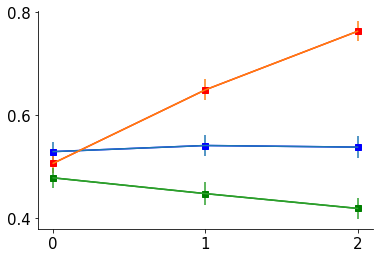

In [76]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

scores_echo = [np.mean(Score_0_echo), np.mean(Score_1_echo), np.mean(Score_2_echo)]
scores_echo_std = [np.std(Score_0_echo), np.std(Score_1_echo), np.std(Score_2_echo)]

scores_pre2 = [np.mean(Scores_0_49[0]), np.mean(Scores_1_49[0]), np.mean(Scores_2_49[0])]
scores_pre2_std = [np.std(Scores_0_49[0]), np.std(Scores_1_49[0]), np.std(Scores_2_49[0])]

scores_pre1 = [np.mean(Score_0), np.mean(Score_1_0), np.mean(Score_2_0)]
scores_pre1_std = [np.std(Score_0), np.std(Score_1_0), np.std(Score_2_0)]
plt.plot(np.arange(3), scores_echo, 'bs-')
p1 = plt.errorbar(np.arange(3), scores_echo, yerr = scores_echo_std/np.sqrt(225))
plt.plot(np.arange(3), scores_pre1, 'rs-')
p1 = plt.errorbar(np.arange(3), scores_pre1, yerr = scores_pre1_std/np.sqrt(225))
plt.plot(np.arange(3), scores_pre2, 'gs-')
p1 = plt.errorbar(np.arange(3), scores_pre2, yerr = scores_pre2_std/np.sqrt(225))
plt.xticks([0, 1, 2], size = 15)
plt.yticks([0.4, 0.6, 0.8], size = 15)

average score of 2 clicks 

### Animation and plot

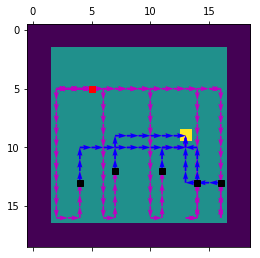

In [134]:
weight = 'weights2/rnn_1515tanh512_checkpoint300_0_5'
size = 15
PC_traces = []
Pretest =  PretrainTest(holes = 0, weight_write = weight, inputs_type=(1, 0)) 
Pretest.game.net.load_state_dict(torch.load(weight))
# torch.manual_seed(5)
hidden = torch.randn(1, 512)
score_2 = []
Y, X = np.meshgrid(np.arange(3, 4, 1), np.arange(0, 17, 4))
for pos in zip(Y, X):
    for i in range(1):
        start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
        start = (5, 5)
        y, x = pos
        
        force_actions = 3 * [3] +  x[0] * [1] + 13 * [2] + y[0] * [0]
        Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 0, size = size, test = 0, hidden = hidden,
                                                                force_actions = force_actions, limit_set = 16)
    #     Pos2, hidden2, dH2, Action, reward2 = trajectory(Pretest.game, start, reward_control = 1, size = size, test = 0)
        start_new = Pos1[len(force_actions)]
        grid = Pretest.game.grid.grid.copy()
        pos_r = (Pretest.game.pos_reward)
        manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
        score_2.append(manhantondist/(len(Pos1)-(len(force_actions))))
        if i == 0 and x == 0 :
            plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        plt.plot(start[1], start[0], 'rs')
        plt.plot(start_new[1], start_new[0], 'ks')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x1[len(force_actions):-1], y1[len(force_actions):-1], x1[len(force_actions)+1:]-x1[len(force_actions):-1], y1[len(force_actions)+1:]-y1[len(force_actions):-1], scale_units='xy', angles='xy', scale=1, color = 'b')


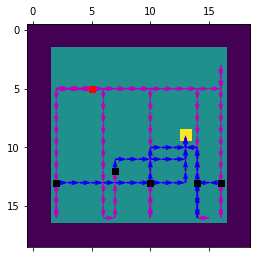

In [140]:
weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_25_4'
size = 15
PC_traces = []
Pretest.game.net.load_state_dict(torch.load(weight))
# torch.manual_seed(5)
hidden = torch.randn(1, 512)
score_2 = []
Y, X = np.meshgrid(np.arange(3, 4, 1), np.arange(0, 17, 4))
for pos in zip(Y, X):
    for i in range(1):
        start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
        start = (5, 5)
        y, x = pos
        
        force_actions = 3 * [3] +  x[0] * [1] + 13 * [2] + y[0] * [0]
        Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 1, size = size, test = 0, hidden = hidden,
                                                                force_actions = force_actions, limit_set = 16)
    #     Pos2, hidden2, dH2, Action, reward2 = trajectory(Pretest.game, start, reward_control = 1, size = size, test = 0)
        start_new = Pos1[len(force_actions)]
        grid = Pretest.game.grid.grid.copy()
        pos_r = (Pretest.game.pos_reward)
        manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
        score_2.append(manhantondist/(len(Pos1)-(len(force_actions))))
        if i == 0 and x == 0 :
            plt.matshow(grid)
        y1 = np.array([p[0] for p in Pos1])
        x1 = np.array([p[1] for p in Pos1])
        plt.plot(start[1], start[0], 'rs')
        plt.plot(start_new[1], start_new[0], 'ks')
        plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')
        plt.quiver(x1[len(force_actions):-1], y1[len(force_actions):-1], x1[len(force_actions)+1:]-x1[len(force_actions):-1], y1[len(force_actions)+1:]-y1[len(force_actions):-1], scale_units='xy', angles='xy', scale=1, color = 'b')


Limit cycle is here to generalize, while it is not a exact limit cycle. It seems that each cycle is lightly different than others. For the first cycles, the structure looks quite a bit the same for 3 pcs for the size 15